In [2]:
library(tidyverse)
library(modeldata)
library(leaps)
library(nnet)
library(caret)
library(corrplot)
library(ISLR)
require(boot)
library(pROC)
library(dplyr)
library(randomForest)
library(keras)

In [3]:
# import the data from the file

data <- read.csv("data/clean_data/for_model_kidney_disease_multi.csv")
head(data)

# transform columns into factors
data$class <- as.factor(data$class)

,age,sg,al,su,bgr,bu,sod,pot,hemo,pcv,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,48,1.020,1,0,121.00,36,137.53,4.63,15.4,44,...,2,1,1,2,2,1,1,1,1,1
2,7,1.020,4,0,148.04,18,137.53,4.63,11.3,38,...,2,1,1,1,1,1,1,1,1,1
3,62,1.010,2,3,423.00,53,137.53,4.63,9.6,31,...,2,1,1,1,2,1,2,1,2,1
4,48,1.005,4,0,117.00,56,111.00,2.50,11.2,32,...,1,2,1,2,1,1,2,2,2,2
5,51,1.010,2,0,106.00,26,137.53,4.63,11.6,35,...,2,1,1,1,1,1,1,1,1,1
6,60,1.015,3,0,74.00,25,142.00,3.20,12.2,39,...,2,1,1,2,2,1,1,2,1,1


In [4]:
# show list of columns and their types
# Getting the types of each column
column_types <- sapply(data, class)

# Print the column types
print(column_types)

      age        sg        al        su       bgr        bu       sod       pot 
"numeric" "numeric" "integer" "integer" "numeric" "numeric" "numeric" "numeric" 
     hemo       pcv      wbcc      rbcc       rbc        pc       pcc        ba 
"numeric" "numeric" "numeric" "numeric" "integer" "integer" "integer" "integer" 
      htn        dm       cad     appet        pe       ane     class 
"integer" "integer" "integer" "integer" "integer" "integer"  "factor" 


In [5]:
# cast the following categorical types into factors
# al, su, rbc, pc, pcc, ba, htn, dm, cad, appet, pe, ane, class
factor_columns <- c("al", "su", "rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane", "class")
data[factor_columns] <- lapply(data[factor_columns], factor)
head(data)

,age,sg,al,su,bgr,bu,sod,pot,hemo,pcv,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,class
,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,48,1.020,1,0,121.00,36,137.53,4.63,15.4,44,...,2,1,1,2,2,1,1,1,1,1
2,7,1.020,4,0,148.04,18,137.53,4.63,11.3,38,...,2,1,1,1,1,1,1,1,1,1
3,62,1.010,2,3,423.00,53,137.53,4.63,9.6,31,...,2,1,1,1,2,1,2,1,2,1
4,48,1.005,4,0,117.00,56,111.00,2.50,11.2,32,...,1,2,1,2,1,1,2,2,2,2
5,51,1.010,2,0,106.00,26,137.53,4.63,11.6,35,...,2,1,1,1,1,1,1,1,1,1
6,60,1.015,3,0,74.00,25,142.00,3.20,12.2,39,...,2,1,1,2,2,1,1,2,1,1


In [6]:
# train test split
set.seed(123)
train_index <- createDataPartition(
  data$class,
  p = .8,
  list = FALSE,
  times = 1
)
data_train <- data[train_index, ]
data_test <- data[-train_index, ]
print(dim(data_train))
print(dim(data_test))
# show label distribution
table(data_train$class)
table(data_test$class)

[1] 321  23
[1] 79 23



  0   1   2 
116  87 118 


 0  1  2 
29 21 29 

In [7]:
# preprocess the data
data_train_numeric <- data_train[, sapply(data_train, is.numeric)]
data_test_numeric <- data_test[, sapply(data_test, is.numeric)]
# Pre-processing steps to handle numerical data
pre_numerical <- preProcess(
  data_train_numeric,
  method = c("center", "scale")
)

# Transforming the data using pre-processing object
train_transformed_numerical <- predict(
  pre_numerical, data_train_numeric
)
test_transformed_numerical <- predict(
  pre_numerical, data_test_numeric
)

# Handling categorical data by creating dummy variables except for the target variable
data_train_categorical <- data_train[, sapply(data_train, is.factor)]
data_test_categorical <- data_test[, sapply(data_test, is.factor)]

# Pre-processing steps to handle categorical data
pre_categorical <- dummyVars(
  ~ . -class,
  data = data_train_categorical
)

# Transforming the data using pre-processing object
train_dummies <- predict(
  pre_categorical, data_train_categorical
)
test_dummies <- predict(
  pre_categorical, data_test_categorical
)

# # Combining the transformed numerical and categorical data
trainFinal <- data.frame(
  train_transformed_numerical,
  train_dummies,
  class = data_train$class
)
testFinal <- data.frame(
  test_transformed_numerical,
  test_dummies,
  class = data_test$class
)
head(trainFinal)
head(testFinal)

,age,sg,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,...,dm.2,cad.1,cad.2,appet.1,appet.2,pe.1,pe.2,ane.1,ane.2,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-0.2391673563,0.3998749,-0.35177930,-0.45231143,0.01866534,0.02212741,1.05457491,0.63858418,-0.21888663,0.586992354,...,1,1,0,1,0,1,0,1,0,1
2,-2.6889537767,0.3998749,0.01196177,-0.81817661,0.01866534,0.02212741,-0.45381081,-0.09762624,-0.96848682,0.006495483,...,0,1,0,1,0,1,0,1,0,1
6,0.4778433034,-0.5370582,-0.98402154,-0.67589571,0.47399228,-0.68372017,-0.12270175,0.02507550,-0.21888663,-0.360757640,...,1,1,0,1,0,0,1,1,0,1
7,0.9558504098,-1.4739914,-0.63427051,-0.08644625,-3.39679602,-0.28884040,-0.04912196,-0.34302971,0.03352874,0.006495483,...,0,1,0,1,0,1,0,1,0,2
8,-1.6731886756,-0.5370582,3.53583788,-0.55394065,0.01866534,0.02212741,-0.04912196,0.63858418,-0.59368672,0.350054856,...,1,1,0,1,0,0,1,1,0,1
9,-0.0001638031,-0.5370582,-0.12309593,0.03550880,0.01866534,0.02212741,-0.63776029,-0.71113492,0.53071356,-0.834632637,...,1,1,0,1,0,1,0,0,1,1


,age,sg,bgr,bu,sod,pot,hemo,pcv,wbcc,rbcc,...,dm.2,cad.1,cad.2,appet.1,appet.2,pe.1,pe.2,ane.1,ane.2,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,0.59734508,-1.4739914,3.71071340,-0.10677210,0.01866534,0.02212741,-1.079239035,-0.95653840,-0.34381999,0.006495483,...,1,1,0,0,1,1,0,0,1,1
4,-0.23916736,-2.4109245,-0.40558715,-0.04579457,-2.68375607,-1.02923996,-0.490600707,-0.83383666,-0.67697563,-0.953101387,...,0,1,0,0,1,0,1,0,1,2
5,-0.05991469,-1.4739914,-0.55355874,-0.65556987,0.01866534,0.02212741,-0.343441124,-0.46573145,-0.42710890,-0.123820141,...,0,1,0,1,0,1,0,1,0,1
18,-0.29891824,0.3998749,-0.44594304,0.58430657,0.16840373,-0.43692031,-0.159491647,0.01035129,0.03352874,0.006495483,...,0,1,0,0,1,1,0,1,0,2
24,-1.85244134,-1.4739914,0.01196177,-0.01672861,0.01866534,0.02212741,-0.001295096,0.01035129,0.03352874,0.006495483,...,0,1,0,0,1,1,0,0,1,2
27,1.37410663,-0.5370582,0.11903939,-0.26937884,0.27026658,-0.58500023,-0.343441124,-0.46573145,0.82222475,-0.834632637,...,1,1,0,0,1,1,0,1,0,2


In [8]:
# create a multi-class logistic regression model using all the features
# split the data into training and testing sets
# load the required library
# fit the model
model <- multinom(class ~ ., data = trainFinal)

prob_predictions <- predict(model, testFinal, type = "probs")

# make predictions
predictions <- predict(model, testFinal)

# confusion matrix
conf_matrix <- confusionMatrix(
  as.factor(predictions), as.factor(testFinal$class)
)
accuracy <- conf_matrix$overall['Accuracy']
precision <- conf_matrix$byClass['Precision']
recall <- conf_matrix$byClass['Recall']
F1 <- conf_matrix$byClass['F1']

# Compute multi-class AUC-ROC
roc_auc <- multiclass.roc(
  as.factor(testFinal$class),
  as.matrix(prob_predictions),
  levels = levels(testFinal$class)
)

# Print the confusion matrix
print(conf_matrix)
cat(sprintf("Accuracy: %f\n", accuracy))
cat(sprintf("Precision: %f\n", precision))
cat(sprintf("Recall: %f\n", recall))
cat(sprintf("F1: %f\n", F1))
cat(sprintf("ROC AUC: %f\n", roc_auc$auc))

# weights:  132 (86 variable)


initial  value 352.654545 
iter  10 value 114.401427
iter  20 value 96.111512
iter  30 value 83.416373
iter  40 value 77.052254
iter  50 value 73.942843
iter  60 value 72.675887
iter  70 value 69.337297
iter  80 value 68.996246
final  value 68.995873 
converged
Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 29  1  2
         1  0 14  4
         2  0  6 23

Overall Statistics
                                          
               Accuracy : 0.8354          
                 95% CI : (0.7351, 0.9094)
    No Information Rate : 0.3671          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7491          
                                          
 Mcnemar's Test P-Value : 0.334           

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.6667   0.7931
Specificity            0.9400   0.9310   0.8800
Pos Pred Value         0.9062  


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




Using Prediction, Reference as id variables



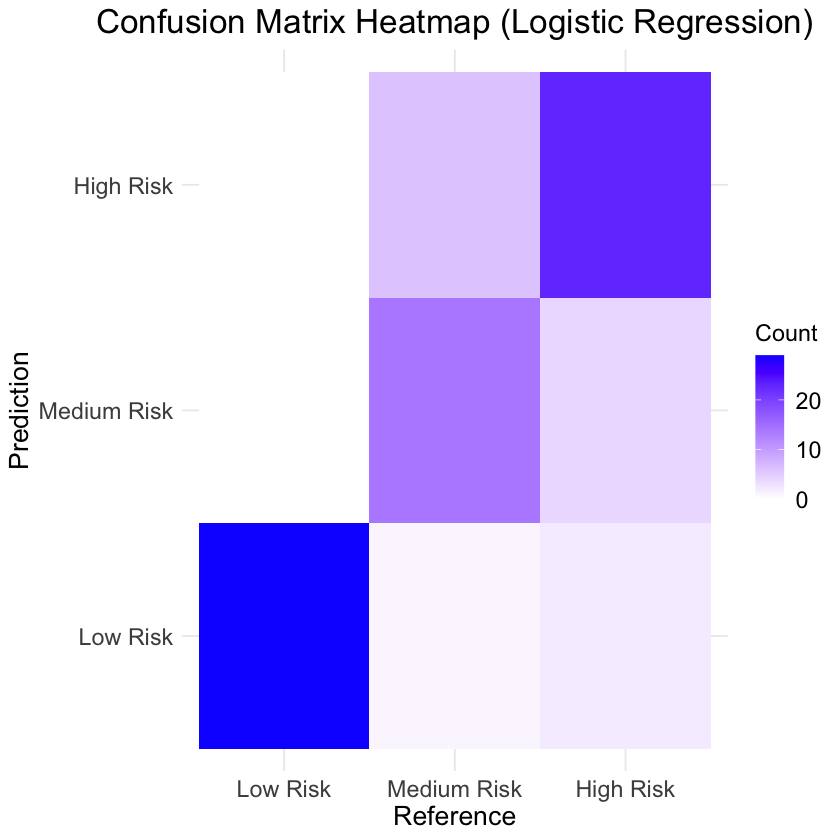

In [9]:
library(ggplot2)     # for plotting
library(reshape2) # for melting the data frame

# create a function to draw the confusion matrix heatmap
draw_confusion_matrix_heatmap <- function(conf_matrix, title = '') {
  # Convert the confusion matrix into a 'table' format and then melt it
  conf_matrix_table <- as.data.frame(conf_matrix$table)

  # convert reference and prediction columns to factors
  conf_matrix_table$Reference <- factor(
    conf_matrix_table$Reference,
    levels = 0:2,
    labels = c("Low Risk", "Medium Risk", "High Risk"),
  )
  conf_matrix_table$Prediction <- factor(
    conf_matrix_table$Prediction,
    levels = 0:2,
    labels = c("Low Risk", "Medium Risk", "High Risk"),
  )
  melted_conf_matrix <- melt(
    conf_matrix_table,
    varnames = c("Reference", "Prediction"),
  )

  # Plotting the heatmap and make the axis labels bit more readable
  ggplot(melted_conf_matrix, aes(x = Reference, y = Prediction, fill = value)) +
    geom_tile() + # This creates the heatmap tiles
    scale_fill_gradient(
      low = "white", high = "#1500ff"
    ) + # Color gradient from white to red
    labs(
      fill = "Count", title = sprintf(
        "Confusion Matrix Heatmap (%s)", title)
    ) + # Labeling
    theme_minimal() + # Minimal theme
    theme(
      axis.text.x = element_text(size = 14),
      axis.text.y = element_text(size = 14),
      axis.title = element_text(size = 16),
      plot.title = element_text(size = 20, hjust = 0.5),
      legend.text = element_text(size = 14),
      legend.title = element_text(size = 14)
    ) # Rotate x-axis labels for better readability
}

# Draw the confusion matrix heatmap
draw_confusion_matrix_heatmap(conf_matrix, 'Logistic Regression')

In [10]:
# Setting up control using caret's rfe function
control <- rfeControl(
  functions = rfFuncs, # Using random forest model functions
  method = "cv", # Cross-validation
  number = 10 # Number of folds in cross-validation
)

results <- rfe(
  trainFinal[, -ncol(trainFinal)], # Features
  trainFinal$class,
  sizes = c(10:20),        # Number of features to include in each iteration
  rfeControl = control
)


In [11]:
# Reviewing results
print(results)



Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
        10   0.8566 0.7827    0.06939 0.10554         
        11   0.8565 0.7822    0.06315 0.09626         
        12   0.8658 0.7964    0.06805 0.10379         
        13   0.8627 0.7918    0.07312 0.11218         
        14   0.8661 0.7964    0.07054 0.10884         
        15   0.8722 0.8058    0.07865 0.12069         
        16   0.8690 0.8006    0.07358 0.11305         
        17   0.8783 0.8153    0.06706 0.10231        *
        18   0.8660 0.7963    0.08222 0.12575         
        19   0.8752 0.8109    0.07572 0.11481         
        20   0.8659 0.7963    0.07118 0.10928         
        42   0.8534 0.7764    0.07546 0.11706         

The top 5 variables (out of 17):
   bu, hemo, pcv, sg, rbcc



Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 29  0  1
         1  0 16  7
         2  0  5 21

Overall Statistics
                                          
               Accuracy : 0.8354          
                 95% CI : (0.7351, 0.9094)
    No Information Rate : 0.3671          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7516          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.7619   0.7241
Specificity            0.9800   0.8793   0.9000
Pos Pred Value         0.9667   0.6957   0.8077
Neg Pred Value         1.0000   0.9107   0.8491
Prevalence             0.3671   0.2658   0.3671
Detection Rate         0.3671   0.2025   0.2658
Detection Prevalence   0.3797   0.2911   0.3291
Balanced Accuracy      0.9900   0.8206   0.8121
ROC A

Using Prediction, Reference as id variables



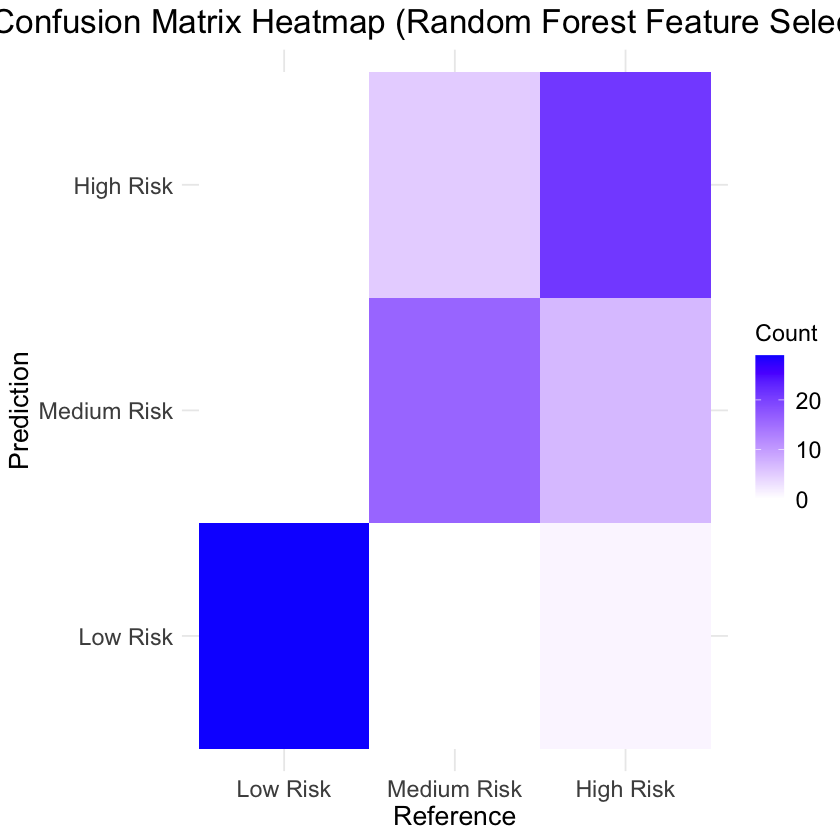

In [12]:
# Using the selected features model to make predictions on the test set
selected_features <- predictors(results)
test_pred <- predict(results$fit, newdata = testFinal[, selected_features])

# Calculate Accuracy
cm_feature_selection <- confusionMatrix(test_pred, testFinal$class)
print(cm_feature_selection)

# Compute multi-class AUC-ROC
prob_predictions <- predict(results$fit, newdata = testFinal[, selected_features], type = "prob")
roc_auc <- multiclass.roc(
  as.factor(testFinal$class),
  as.matrix(prob_predictions),
  levels = levels(testFinal$class)
)

cat(sprintf("ROC AUC: %f\n", roc_auc$auc))
draw_confusion_matrix_heatmap(cm_feature_selection, "Random Forest Feature Selection")

In [13]:
print(selected_features)

 [1] "bu"      "hemo"    "pcv"     "sg"      "rbcc"    "bgr"     "sod"    
 [8] "al.0"    "htn.2"   "htn.1"   "dm.1"    "dm.2"    "appet.1" "appet.2"
[15] "pc.2"    "age"     "su.0"   


In [14]:
# combine the selected features with the target variable
trainFinal_selected <- trainFinal[, c(selected_features, "class")]
testFinal_selected <- testFinal[, c(selected_features, "class")]
head(trainFinal_selected)
head(testFinal_selected)

,bu,hemo,pcv,sg,rbcc,bgr,sod,al.0,htn.2,htn.1,dm.1,dm.2,appet.1,appet.2,pc.2,age,su.0,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-0.45231143,1.05457491,0.63858418,0.3998749,0.586992354,-0.35177930,0.01866534,0,1,0,0,1,1,0,1,-0.2391673563,1,1
2,-0.81817661,-0.45381081,-0.09762624,0.3998749,0.006495483,0.01196177,0.01866534,0,0,1,1,0,1,0,1,-2.6889537767,1,1
6,-0.67589571,-0.12270175,0.02507550,-0.5370582,-0.360757640,-0.98402154,0.47399228,0,1,0,0,1,1,0,1,0.4778433034,1,1
7,-0.08644625,-0.04912196,-0.34302971,-1.4739914,0.006495483,-0.63427051,-3.39679602,1,0,1,1,0,1,0,1,0.9558504098,1,2
8,-0.55394065,-0.04912196,0.63858418,-0.5370582,0.350054856,3.53583788,0.01866534,0,0,1,0,1,1,0,0,-1.6731886756,0,1
9,0.03550880,-0.63776029,-0.71113492,-0.5370582,-0.834632637,-0.12309593,0.01866534,0,1,0,0,1,1,0,0,-0.0001638031,1,1


,bu,hemo,pcv,sg,rbcc,bgr,sod,al.0,htn.2,htn.1,dm.1,dm.2,appet.1,appet.2,pc.2,age,su.0,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3,-0.10677210,-1.079239035,-0.95653840,-1.4739914,0.006495483,3.71071340,0.01866534,0,0,1,0,1,0,1,1,0.59734508,0,1
4,-0.04579457,-0.490600707,-0.83383666,-2.4109245,-0.953101387,-0.40558715,-2.68375607,0,1,0,1,0,0,1,0,-0.23916736,1,2
5,-0.65556987,-0.343441124,-0.46573145,-1.4739914,-0.123820141,-0.55355874,0.01866534,0,0,1,1,0,1,0,1,-0.05991469,1,1
18,0.58430657,-0.159491647,0.01035129,0.3998749,0.006495483,-0.44594304,0.16840373,1,1,0,1,0,0,1,1,-0.29891824,1,2
24,-0.01672861,-0.001295096,0.01035129,-1.4739914,0.006495483,0.01196177,0.01866534,1,0,1,1,0,0,1,1,-1.85244134,1,2
27,-0.26937884,-0.343441124,-0.46573145,-0.5370582,-0.834632637,0.11903939,0.27026658,1,1,0,0,1,0,1,1,1.37410663,1,2


In [15]:

# prepare the data for keras
# Convert the target variable to 0-indexed integers
train_labels <- as.integer(as.factor(trainFinal$class)) - 1  # Convert factors to 0-indexed integers
num_classes <- length(unique(train_labels)) # Get the number of unique classes
train_labels <- to_categorical(train_labels, num_classes) # Convert to one-hot encoding

# # using selected features
model <- keras_model_sequential() %>%
  layer_dense(
    units = 50, activation = "relu", input_shape = c(ncol(trainFinal_selected) - 1)
  ) %>%
  layer_dense(units = num_classes, activation = "softmax")

# Compile the model
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = "rmsprop", # Or optimizer_rmsprop()
  metrics = list("accuracy")
)

# Train the model
history <- model %>% fit(
  x = as.matrix(trainFinal_selected[, -ncol(trainFinal_selected)]),
  y = train_labels,
  epochs = 100,
  batch_size = 32,
  validation_split = 0.2
)


ERROR: Error in (structure(function (x, num_classes = NULL) : unused arguments (y = c(1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 
2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), dtype = "float32")


loss  accuracy 
0.4836242 0.7974684

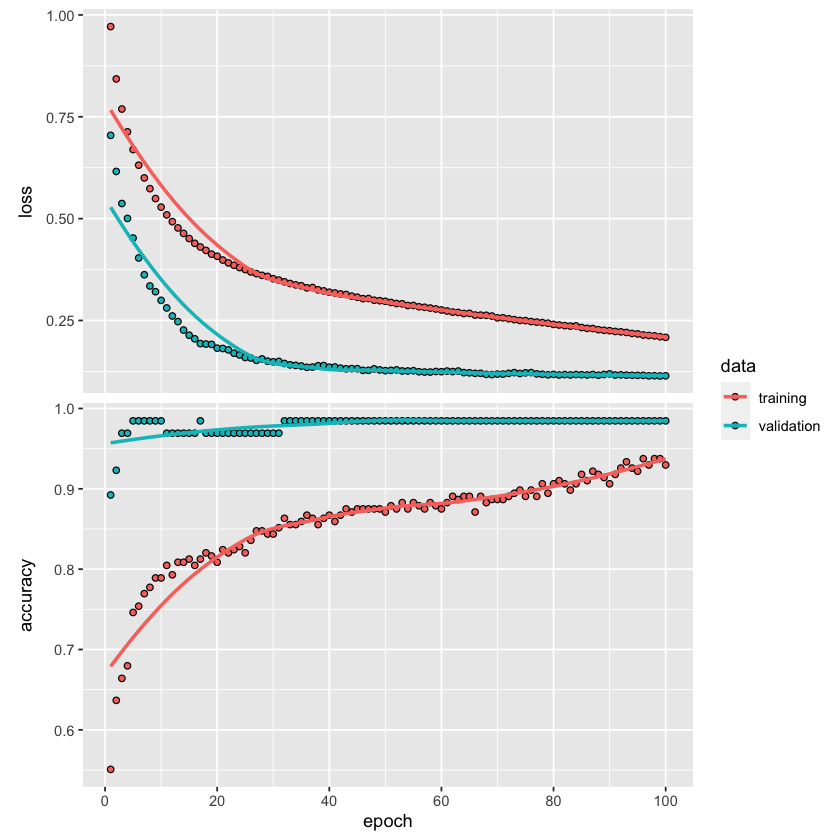

In [ ]:
# module evaluation
# Convert the target variable to 0-indexed integers
test_labels <- as.integer(as.factor(testFinal_selected$class)) - 1 # Convert factors to 0-indexed integers

# Convert to one-hot encoding
test_labels <- to_categorical(test_labels, num_classes)

# Evaluate the model
model %>% evaluate(
  x = as.matrix(testFinal_selected[, -ncol(testFinal_selected)]),
  y = test_labels
)
# Plot the training history into two plots
plot(history)

# Predictions
prob_predictions <- model %>% predict(
  as.matrix(testFinal_selected[, -ncol(testFinal_selected)])
)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 29  1  2
         1  0 14  4
         2  0  6 23

Overall Statistics
                                          
               Accuracy : 0.8354          
                 95% CI : (0.7351, 0.9094)
    No Information Rate : 0.3671          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7491          
                                          
 Mcnemar's Test P-Value : 0.334           

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.6667   0.7931
Specificity            0.9400   0.9310   0.8800
Pos Pred Value         0.9062   0.7778   0.7931
Neg Pred Value         1.0000   0.8852   0.8800
Prevalence             0.3671   0.2658   0.3671
Detection Rate         0.3671   0.1772   0.2911
Detection Prevalence   0.4051   0.2278   0.3671
Balanced Accuracy      0.9700   0.7989   0.8366
ROC A

Using Prediction, Reference as id variables



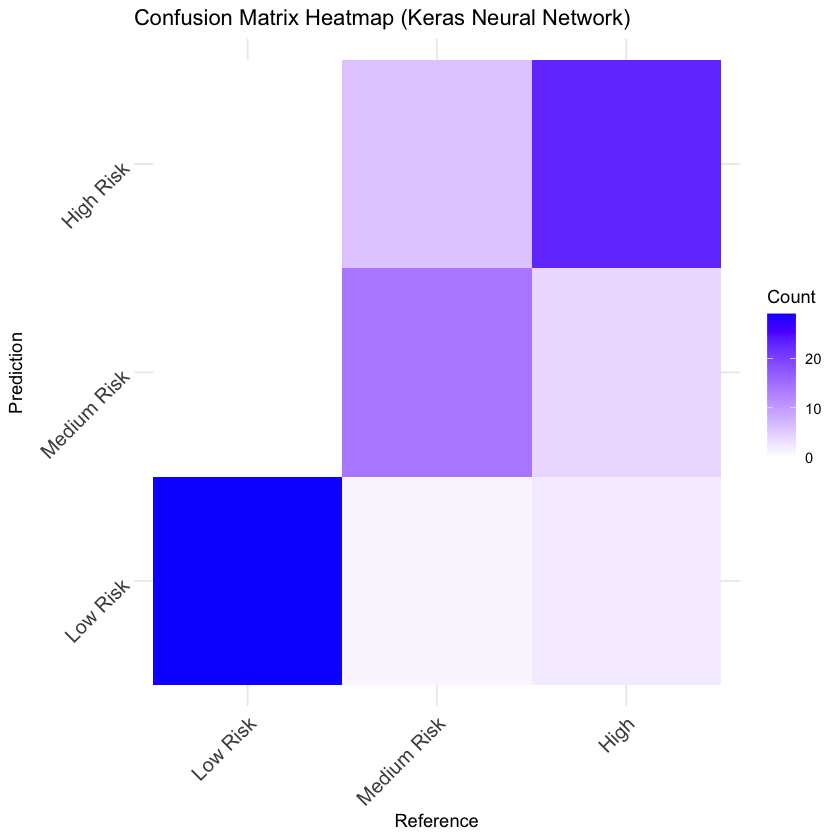

In [ ]:
# print test metrics
# confusion matrix
conf_matrix <- confusionMatrix(
  as.factor(predictions), as.factor(testFinal_selected$class)
)
print(conf_matrix)
# Check the levels of the response variable
response_levels <- levels(testFinal_selected$class)

# And your predictor matrix needs to have these column names in the same order
colnames(prob_predictions) <- response_levels

# Compute multi-class AUC-ROC
roc_auc <- multiclass.roc(
  as.factor(testFinal_selected$class),
  prob_predictions,
  levels = levels(testFinal_selected$class)
)

cat(sprintf("ROC AUC: %f\n", roc_auc$auc))

draw_confusion_matrix_heatmap(conf_matrix, "Keras Neural Network")

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 29  0  1
         1  0 18  7
         2  0  3 21

Overall Statistics
                                          
               Accuracy : 0.8608          
                 95% CI : (0.7645, 0.9284)
    No Information Rate : 0.3671          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7906          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.8571   0.7241
Specificity            0.9800   0.8793   0.9400
Pos Pred Value         0.9667   0.7200   0.8750
Neg Pred Value         1.0000   0.9444   0.8545
Prevalence             0.3671   0.2658   0.3671
Detection Rate         0.3671   0.2278   0.2658
Detection Prevalence   0.3797   0.3165   0.3038
Balanced Accuracy      0.9900   0.8682   0.8321
ROC A

Using Prediction, Reference as id variables



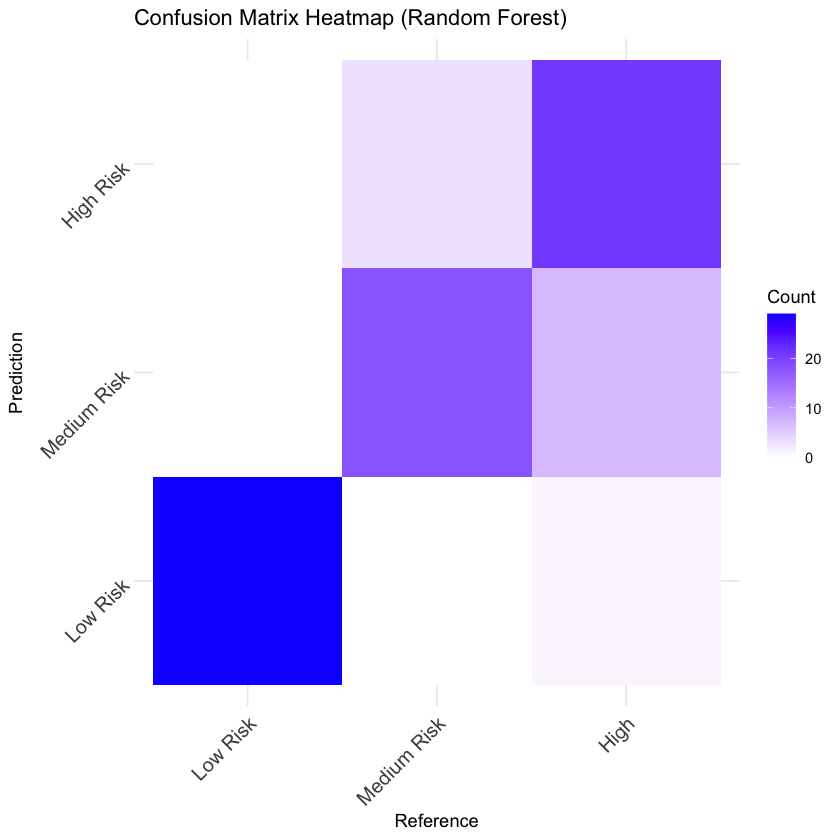

In [ ]:
# use random forest model
library(randomForest)

set.seed(123)

model <- randomForest(
  class ~ .,
  data = trainFinal_selected,
  ntree = 500
)

# make predictions
predictions <- predict(model, testFinal_selected)

# calculate the cm
conf_matrix <- confusionMatrix(
  as.factor(predictions), as.factor(testFinal_selected$class)
)

# print the confusion matrix
print(conf_matrix)

# Compute multi-class AUC-ROC
prob_predictions <- predict(model, testFinal_selected, type = "prob")

roc_auc <- multiclass.roc(
  as.factor(testFinal_selected$class),
  as.matrix(prob_predictions),
  levels = levels(testFinal_selected$class)
)

cat(sprintf("ROC AUC: %f\n", roc_auc$auc))

draw_confusion_matrix_heatmap(conf_matrix, "Random Forest")

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 28  2  1
         1  1 13  8
         2  0  6 20

Overall Statistics
                                        
               Accuracy : 0.7722        
                 95% CI : (0.664, 0.859)
    No Information Rate : 0.3671        
    P-Value [Acc > NIR] : 2.477e-13     
                                        
                  Kappa : 0.6554        
                                        
 Mcnemar's Test P-Value : 0.6551        

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9655   0.6190   0.6897
Specificity            0.9400   0.8448   0.8800
Pos Pred Value         0.9032   0.5909   0.7692
Neg Pred Value         0.9792   0.8596   0.8302
Prevalence             0.3671   0.2658   0.3671
Detection Rate         0.3544   0.1646   0.2532
Detection Prevalence   0.3924   0.2785   0.3291
Balanced Accuracy      0.9528   0.7319   0.7848


Using Prediction, Reference as id variables



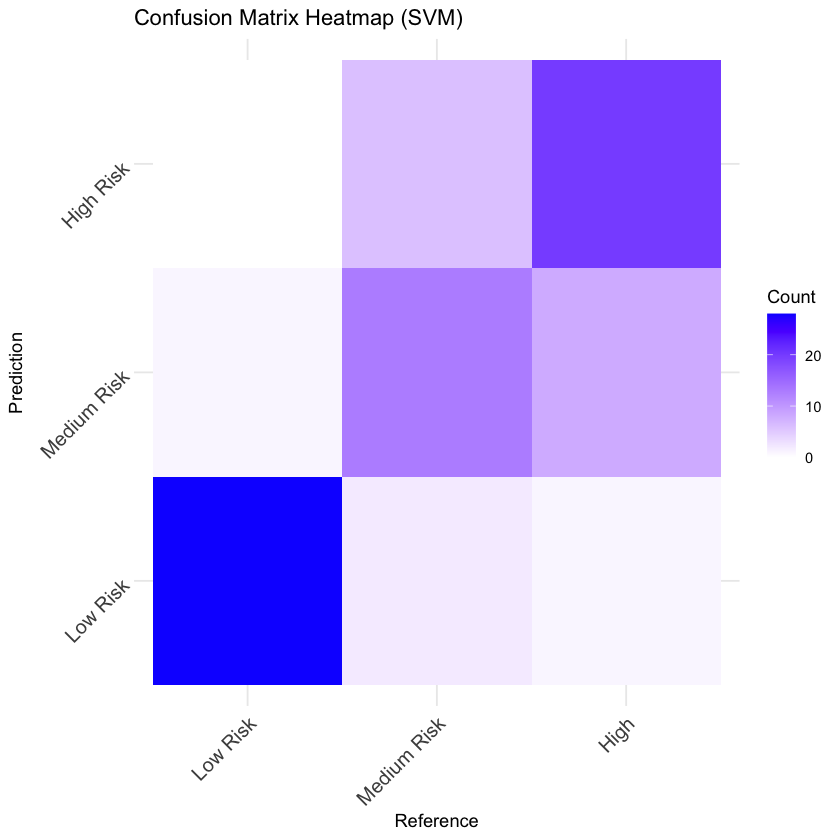

In [ ]:
# SVM
library(e1071)

model <- svm(
  class ~ .,
  data = trainFinal_selected,
  kernel = "linear",
  probability = TRUE
)

# make predictions
predictions <- predict(model, testFinal_selected)

# calculate the cm
conf_matrix <- confusionMatrix(
  as.factor(predictions), as.factor(testFinal_selected$class)
)

# print the confusion matrix
print(conf_matrix)

draw_confusion_matrix_heatmap(conf_matrix, "SVM")

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 29  3  2
         1  0 12 10
         2  0  6 17

Overall Statistics
                                          
               Accuracy : 0.7342          
                 95% CI : (0.6228, 0.8273)
    No Information Rate : 0.3671          
    P-Value [Acc > NIR] : 3.595e-11       
                                          
                  Kappa : 0.5979          
                                          
 Mcnemar's Test P-Value : 0.1116          

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000   0.5714   0.5862
Specificity            0.9000   0.8276   0.8800
Pos Pred Value         0.8529   0.5455   0.7391
Neg Pred Value         1.0000   0.8421   0.7857
Prevalence             0.3671   0.2658   0.3671
Detection Rate         0.3671   0.1519   0.2152
Detection Prevalence   0.4304   0.2785   0.2911
Balanced Accuracy      0.9500   0.6995   0.7331


Using Prediction, Reference as id variables



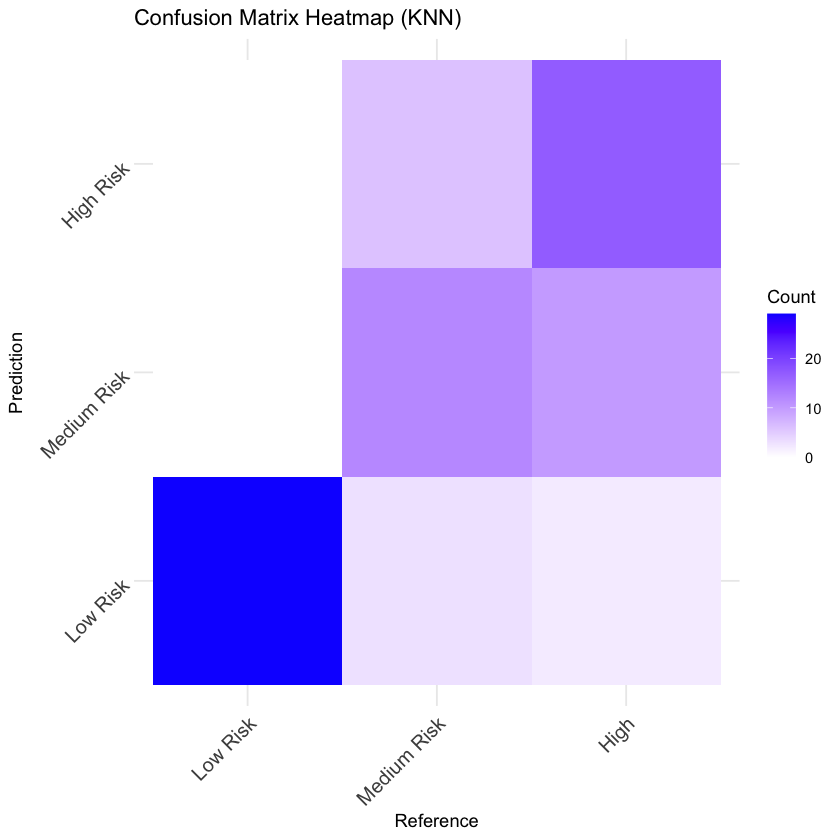

In [ ]:
# KNN
library(class)

set.seed(123)

model <- knn(
  train = trainFinal_selected[, -ncol(trainFinal_selected)],
  test = testFinal_selected[, -ncol(testFinal_selected)],
  cl = trainFinal_selected$class,
  k = 5
)

# make predictions
predictions <- as.factor(model)

# calculate the cm
conf_matrix <- confusionMatrix(
  as.factor(predictions), as.factor(testFinal_selected$class)
)

# print the confusion matrix
print(conf_matrix)

draw_confusion_matrix_heatmap(conf_matrix, "KNN")

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2
         0 29 11  9
         1  0  6  3
         2  0  4 17

Overall Statistics
                                          
               Accuracy : 0.6582          
                 95% CI : (0.5429, 0.7613)
    No Information Rate : 0.3671          
    P-Value [Acc > NIR] : 1.447e-07       
                                          
                  Kappa : 0.4697          
                                          
 Mcnemar's Test P-Value : 0.0001586       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            1.0000  0.28571   0.5862
Specificity            0.6000  0.94828   0.9200
Pos Pred Value         0.5918  0.66667   0.8095
Neg Pred Value         1.0000  0.78571   0.7931
Prevalence             0.3671  0.26582   0.3671
Detection Rate         0.3671  0.07595   0.2152
Detection Prevalence   0.6203  0.11392   0.2658
Balanced Accuracy      0.8000  0.61700   0.7531


Using Prediction, Reference as id variables



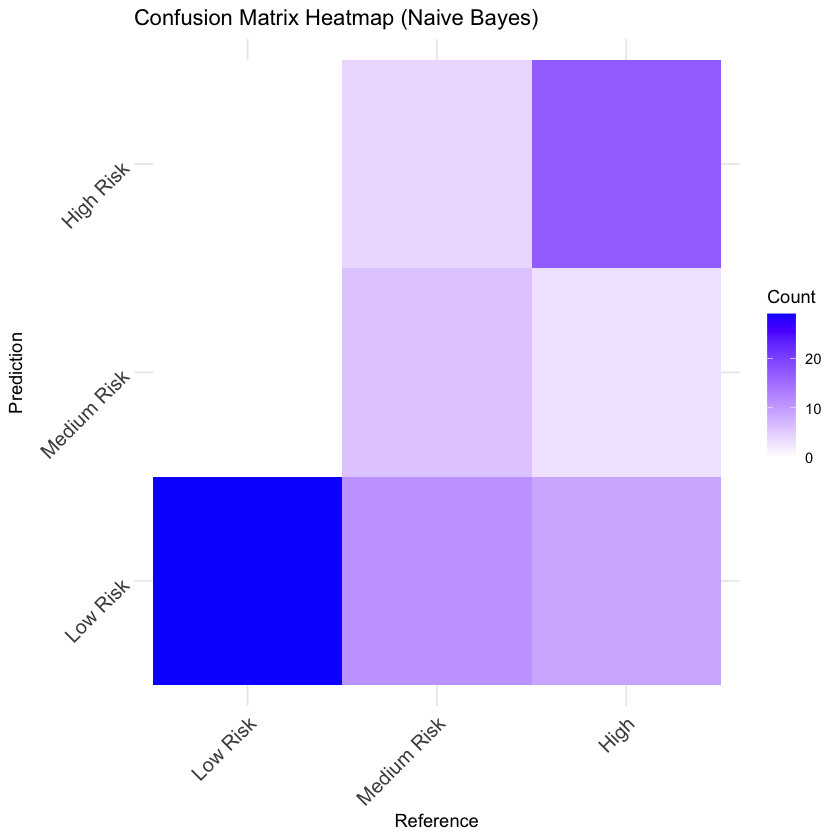

In [ ]:
# Naive Bayes
library(e1071)

set.seed(123)

model <- naiveBayes(
  class ~ .,
  data = trainFinal_selected
)

# make predictions
predictions <- predict(model, testFinal_selected)

# calculate the cm
conf_matrix <- confusionMatrix(
  as.factor(predictions), as.factor(testFinal_selected$class)
)

# print the confusion matrix
print(conf_matrix)

draw_confusion_matrix_heatmap(conf_matrix, "Naive Bayes")